# Bayesian Statistics
## Mini Project

In [1]:
# import packages

import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

In [2]:
medical = pd.read_csv('../SB_Files/Bayesian_stats_Q6.28/data/insurance2.csv')

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

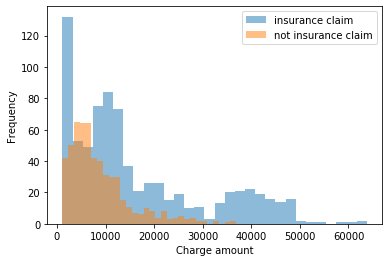

In [5]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

We may suspect from the above that there is some sort of exponential-like distribution at play here. The charges that were not insurance claims seem most like this. The insurance claim charges may possibly be multimodal. The gamma distribution may be applicable and we could test this for the distribution of charges that weren't insurance claims first. Developing our new method for the easiest looking case first is a common and sound approach that can demonstrate a minimum viable solution/product and get, or keep, stakeholders on board.

### Initial parameter estimation

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made as described [here](https://wiki.analytica.com/index.php?title=Gamma_distribution).

In [6]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

### Initial simulation

Let's draw the same number of random variates from this distribution and compare to our observed data.

In [7]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

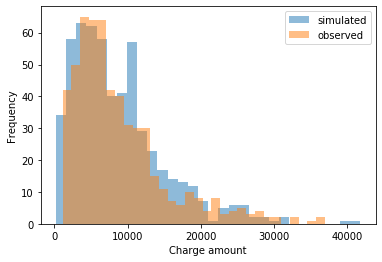

In [8]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

Well it doesn't look too bad! We're not a million miles off. But can we do better? We have a plausible form for the distribution of charge amounts and potential values for that distribution's parameters so we can already draw random variates from that distribution to perform simulations. But we don't know if we have a _best_ estimate for the population parameters, and we also only have a single estimate each for $\alpha$ and $\beta$; we aren't capturing our uncertainty in their values. Can we take a Bayesian inference approach to estimate the parameters?

### Creating a PyMC3 model

In [9]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then, before that, you need to create those stochastic variables using `pm.Exponential` and the correct parameters.

__A:__
- See code below for running the model

In [10]:
# Run model

with pm.Model() as model:
    alpha_ = pm.Exponential("alpha_", 1/alpha_est)
    rate_ = pm.Exponential("rate_", 1/rate_est)
    # obs = no_insurance
    
    obs = pm.Gamma("obs", alpha=alpha_, beta=rate_, observed=no_insurance)
    
    trace = pm.sample(draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate_, alpha_]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 42000/42000 [00:21<00:00, 1928.39draws/s]


If you get a warning about acceptance probability not matching the target, and that it's around 0.88 when it should be close to 0.8, don't worry. We encourage you to read up on this and see if you can adjust the parameters and/or arguments to pm.sample, but if your model runs without any additional warnings or errors then you should be doing great!

__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

__A:__
- The `pm.summary(trace)` provides the hpd_2.5 and hpd_97.5 (95% credible interval) for alpha_ and rate_
    - The 95% confidence interval for alpha is 1.987307 to 2.475689
    - The value of beta and the 95% confidence interval for beta are calculated in the cell below
        - 3529.014830604412  to  4522.014732070848
- See plots below with credible intervals
- The plots look ok to me. I would expect bad plots to have a much wider distribution, with more uncertainty around the mean of the distribution (which is the estimate from the model).

In [11]:
# the summary for trace displays the estimate for alpha and the rate (1/beta)
# the hpd values in the dataframe provide the limits of the 95% credible interval
summary = pm.summary(trace)
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_,2.228373,0.124778,1.076126e-03,1.987307,2.475689,10836.387173,0.999997
rate_,0.000253,0.000016,1.346646e-07,0.000221,0.000283,10757.016073,0.999961


In [12]:
# calculate beta and 95% conf interval
beta_mean = 1/summary.loc['rate_', 'mean']
b_upper = 1/summary.loc['rate_', 'hpd_2.5']
b_lower = 1/summary.loc['rate_', 'hpd_97.5']
print('beta mean estimate: ', beta_mean)
print('beta 95% confidence interval: ', b_lower, ' to ', b_upper)

beta mean estimate:  3959.30800570918
beta 95% confidence interval:  3529.014830604412  to  4522.014732070848


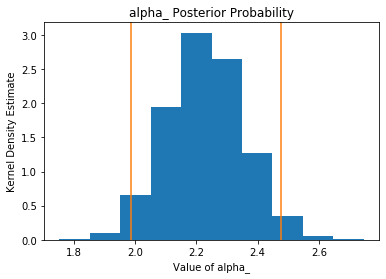

In [13]:
# create the hist of the alpha returned from the model
_ = plt.hist(trace.alpha_, density=True)
_ = plt.axvline(summary.loc['alpha_','hpd_2.5'], color='C1')
_ = plt.axvline(summary.loc['alpha_', 'hpd_97.5'], color='C1')
_ = plt.title('alpha_ Posterior Probability')
_ = plt.xlabel('Value of alpha_')
_ = plt.ylabel('Kernel Density Estimate')

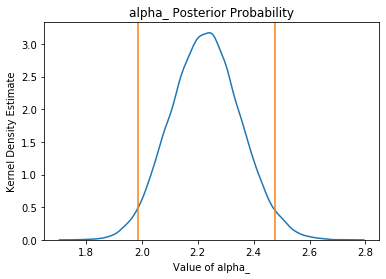

In [14]:
# create the distribution plot for alpha from the model
_ = sns.distplot(trace.alpha_, kde=True, hist=False)
_ = plt.axvline(summary.loc['alpha_','hpd_2.5'], color='C1')
_ = plt.axvline(summary.loc['alpha_', 'hpd_97.5'], color='C1')
_ = plt.title('alpha_ Posterior Probability')
_ = plt.xlabel('Value of alpha_')
_ = plt.ylabel('Kernel Density Estimate')

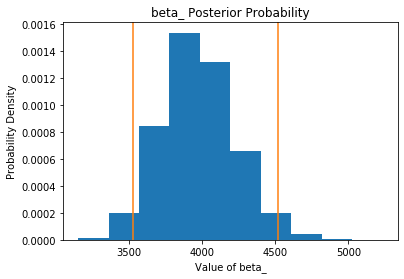

In [15]:
# convert the rate data to estimates of beta
beta_ = 1/trace.rate_

# create and show the histogram
_ = plt.hist(beta_, density=True)
_ = plt.axvline(b_lower, color='C1')
_ = plt.axvline(b_upper, color='C1')
_ = plt.title('beta_ Posterior Probability')
_ = plt.xlabel('Value of beta_')
_ = plt.ylabel('Probability Density')

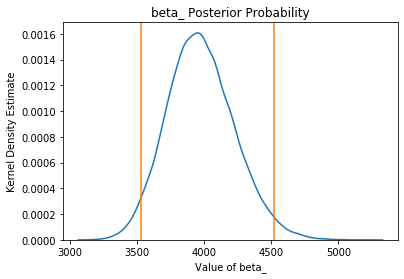

In [16]:
# create and display the distribution plot for beta
_ = sns.distplot(beta_, kde=True, hist=False)
_ = plt.axvline(b_lower, color='C1')
_ = plt.axvline(b_upper, color='C1')
_ = plt.title('beta_ Posterior Probability')
_ = plt.xlabel('Value of beta_')
_ = plt.ylabel('Kernel Density Estimate')

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

__A:__
- They appear normally distributed
    - The plot for alpha resembles the plot I did
    - The plot for the rate is not comparable to the plot of beta I made, making a plot of the rate for comparision
        - my distribution plot of rate_ resembles that from the traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000285ED2FB550>,
      dtype=object)

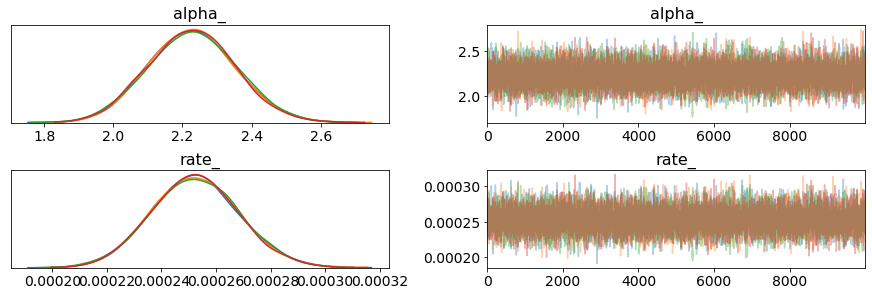

In [17]:
pm.traceplot(trace)

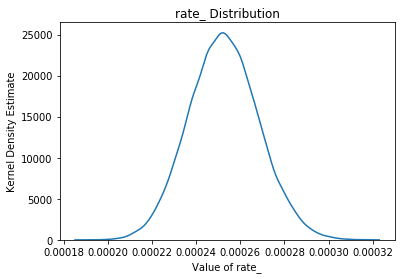

In [18]:
# plot the rate_ distribution for comparison to the traceplot
_ = sns.distplot(trace.rate_, kde=True, hist=False)
_ = plt.title('rate_ Distribution')
_ = plt.xlabel('Value of rate_')
_ = plt.ylabel('Kernel Density Estimate')

__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

__A:__
- I'd say the model performance is a little better on the lower range of charges
- The worst performance of the model is still around 10000 and 15000 medical charges, however the performance seems overall improved vs. the original model
- Just to verify, I created a plot of the difference between each model and the observed values
    - The Bayes Model appears to have a tighter distribution
- To provide additional verification, I calculated the standard deviation of the difference between each model and the observed values
    - This standard deviation showed that the Bayes Model had a lower deviation from the observed values.

In [19]:
# store the posterior mean values for alpha and beta
alpha_post = summary.loc['alpha_', 'mean']
beta_post = beta_mean

In [20]:
seed(47)
best_shot_simulated = gamma(alpha_post, scale=beta_post).rvs(n_no_ins)

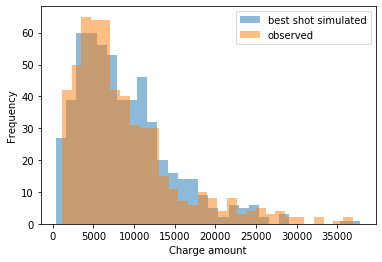

In [21]:
# overlay the best shot simulated data on the observed data
_ = plt.hist(best_shot_simulated, bins=30, alpha=0.5, label='best shot simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

In [22]:
# plot model deviation from oberved values to compare model performance
orig_model_dev = no_insurance - no_ins_model_rvs
bayes_model_dev = no_insurance - best_shot_simulated

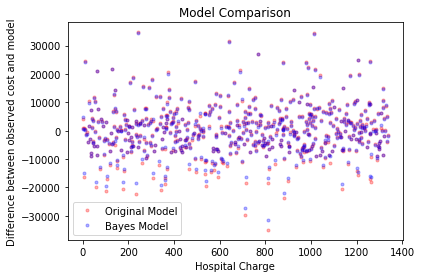

In [23]:
# plot the difference between observed values and the modeled values
_ = plt.plot(orig_model_dev, marker='.', linestyle='none', alpha=0.3, color='red', label='Original Model')
_ = plt.plot(bayes_model_dev, marker='.', linestyle='none', alpha=0.3, color='blue', label='Bayes Model')
_ = plt.title('Model Comparison')
_ = plt.xlabel('Hospital Charge')
_ = plt.ylabel('Difference between observed cost and model')
_ = plt.legend(loc='best')

In [24]:
# display the standard deviation in the model performance relative to the observed data
# a lower value means overall better estimation of observed data
print('Original Model Std: ', np.std(orig_model_dev))
print('Bayes Model Std: ', np.std(bayes_model_dev))

Original Model Std:  8801.529207827116
Bayes Model Std:  8449.18934991746


## Summary

In this exercise, we have postulated a distribution to describe the individual charge amounts for non-insured cases. This distribution has two required parameters, which we do not know, but we used PyMC3 to perform Bayesian inference to find our level of "belief" in a range of values for them. We then used the average parameter values to create one simulated data set of the same size as the original, but the distribution of our posteriors for these parameters will allow us to perform simulations of any sample size we desire and for a range of scenarios of different $\alpha$ and $\beta$. This could be a powerful tool to model different financial conditions for the hospital. 

Well done making it through this tricky subject. Starting think Bayesian _and_ starting to get to grips with something like PyMC3 is no easy task. As a data scientist, the most important thing is to be aware that this statistical approach exists, though you may not actually use this approach as much as you use the other approaches you've learned about. Still, we encourage you to think of ways that this approach could apply to the work that you do in this course and throughout your career.  